[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/05_handwritten_gpu.ipynb)

## **Thai-digit handwritten classification with Pytorch: Exploration**

This notebook takes the previous classification code and implements the following:
- Training the model on GPU
- Save best validation model

## **Download and clean the dataset from the repository**

- We have downloaded the data from https://github.com/kittinan/thai-handwriting-number by cloning the repository
- Remove files that have character mismatch (as suggested by the the creator)
- Then, we put the cleaned data at https://github.com/biodatlab/deep-learning-skooldio

In [1]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

In [2]:
import os
import os.path as op
from glob import glob
from pathlib import Path
import random
from PIL import Image
from collections import Counter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

In [4]:
directory = "deep-learning-skooldio/"
paths = glob(op.join(directory, "thai-handwritten-dataset", "*", "*"))
num_samples = len(paths)
print("Number of samples", num_samples)

Number of samples 1750


In [5]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil

train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42)
for i in range(10):
    os.makedirs(f"data/train/{i}", exist_ok=True)
    os.makedirs(f"data/validation/{i}", exist_ok=True)

In [6]:
def copy_to_destination(src_paths, dst_path: str = "data/train/"):
    for path in tqdm(src_paths):
        path = Path(path)
        if path.parent.name == "10":
            parent_dir = "0"
        else:
            parent_dir = path.parent.name
        shutil.copy(path, op.join(dst_path, parent_dir, path.name))

In [7]:
copy_to_destination(train_paths, "data/train/")
copy_to_destination(test_paths, "data/validation/")

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

## **Create a custom dataset and a dataloader**

In [8]:
# Create dataframe
train_df = pd.DataFrame({"path": glob("data/train/*/*")})
val_df = pd.DataFrame({"path": glob("data/validation/*/*")})

# Create text column from path
train_df["text"] = train_df["path"].apply(lambda x: int(Path(x).parent.name))
val_df["text"] = val_df["path"].apply(lambda x: int(Path(x).parent.name))

# Shape of dataframe
print("Number of train images = {}, number of validation images = {},".format(train_df.shape, val_df.shape))

Number of train images = (1575, 2), number of validation images = (175, 2),


In [9]:
class ThaiDigitDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.transform = transform
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = int(self.dataframe['text'][idx])
        image = Image.open(self.dataframe['path'][idx])
        if self.transform:
            image = 1 - self.transform(image)
        return image, label

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=(-15, 15), translate=(0.05, 0.1), scale=(1, 1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [11]:
train_thaidigit_dataset = ThaiDigitDataset(train_df, transform=val_transform)
augmented_train_dataset = ThaiDigitDataset(train_df, transform=train_transform)
train_dataset = ConcatDataset([train_thaidigit_dataset, augmented_train_dataset])
val_dataset = ThaiDigitDataset(val_df, transform=val_transform)

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In this time we will train model using GPU (CUDA). We can check if cuda is available or not by using `torch.cuda.is_available()`.

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
# Modify the train function to train with cuda
def train(model, n_epochs, loss_function, optimizer, train_loader, validation_loader):
    training_logs = {"train_loss": [],  "train_acc": [], "val_loss": [], "val_acc": []}
    print("-"*80)
    model.train()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device) # move model to GPU
    for epoch in range(1, n_epochs+1):
        # training
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            # Change device to cuda!
            # Move the data to GPU
            images, labels = images.to(device), labels.to(device) 
            pred = model(images)
            loss = loss_function(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save training logs
        training_logs["train_loss"].append(train_loss/ len(train_loader))
        training_logs["train_acc"].append(correct / len(train_loader.dataset))

        # validation
        model.eval()
        val_loss, correct = 0, 0
        for images, labels in validation_loader:

            #!! Change device to cuda
            images = images.to("cuda")
            labels = labels.to("cuda") 
            pred = model(images)
            val_loss += loss_function(pred, labels).item()
            correct += (pred.argmax(1) == labels).float().sum().item()

        #!! Save best model
        # If training_logs["val_loss"] is not empty
        if len(training_logs["val_loss"]):
            # If the current validation loss is lower than the previous validation loss
            # So we save the model
            if min(training_logs["val_loss"]) > (val_loss/ len(validation_loader)):
                save_path = "thai_digit.pth"
                torch.save(model.state_dict(), save_path)  # save model parameters
  
        # save validation logs
        training_logs["val_loss"].append(val_loss/ len(validation_loader))
        training_logs["val_acc"].append(correct / len(validation_loader.dataset))

        print(f"Epochs {epoch}".ljust(10), 
              f"train loss {training_logs['train_loss'][-1]:.5f}",
              f"train acc {training_logs['train_acc'][-1]:.5f}",

              f"val loss {training_logs['val_loss'][-1]:.5f}",
              f"val acc {training_logs['val_acc'][-1]:.5f}",
              )
        print("-"*80)
    return model, training_logs

In [15]:
# evaluate function code from previous exercise
def evaluate(dataframe, model):
    model.eval()
    results = dataframe.copy()
    predictions = []
    for idx, row in results.iterrows():
        img = val_transform(Image.open(row.path))
        pred = model(1 - img)
        predictions.append(pred.argmax(1).item())

    results["prediction"] = predictions
    # Calculate accuracy
    accuracy = len(results[results.prediction == results.text]) / len(results)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return results

In [16]:
class DropoutThaiDigit(nn.Module):
    def __init__(self):
        super(DropoutThaiDigit, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 392),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(196, 98),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(98, 10),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.layers(x)

In [17]:
n_epochs = 40
loss_fn = nn.CrossEntropyLoss()
model = DropoutThaiDigit()  # Initialize the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [18]:
model, augmented_model_history = train(
    model, n_epochs, loss_fn, optimizer, train_dataloader, val_dataloader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30333 train acc 0.10063 val loss 2.30091 val acc 0.08571
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30085 train acc 0.10222 val loss 2.29964 val acc 0.08571
--------------------------------------------------------------------------------
Epochs 3   train loss 2.29849 train acc 0.10667 val loss 2.29778 val acc 0.08571
--------------------------------------------------------------------------------
Epochs 4   train loss 2.29594 train acc 0.11619 val loss 2.29533 val acc 0.09714
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29303 train acc 0.15524 val loss 2.29186 val acc 0.16000
--------------------------------------------------------------------------------
Epochs 6   train loss 2.28861 train acc 0.18952 val loss 2.28710 val acc 0.23429
----------------------------

In [19]:
torch.save(model.state_dict(), "thai_digit.pth")

## Use the model

- You can use a similar inference as the CPU version
- However, do not forget to move the model and data to the same device (CPU or GPU)

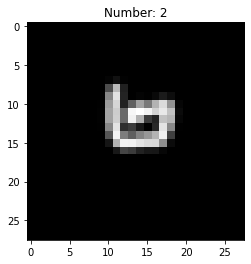

In [20]:
img = Image.open(paths[100])
img = (1 - val_transform(img))
plt.title("Number: {}".format(Path(paths[100]).parent.name))
plt.imshow(img.squeeze(0), cmap="gray")
plt.show()

In [21]:
# Error since the data is not on the same device as the model
model(img)

RuntimeError: ignored

There is a error in the code but why? <br />
Because the in train function, the data is not transfer to cuda device. <br />
So, we need to modify the train function to transfer the data to cuda device.

In [22]:
pred = model(img.to(device))
# pred = int(pred.argmax(dim=1))

In [23]:
int(pred.detach().cpu().argmax(dim=1)) # detach from GPU

2

And the rest is the same as before

## **Load model and specify device**

Use `map_location` to specify the location of loaded parameters

```py
model.load_state_dict(torch.load(model_path, map_location=torch.device("cuda")))
```

In [35]:
# Load best model
model_path = "thai_digit.pth"
model = DropoutThaiDigit().cuda()  # initialize the model
# load the model weights, specifying the device to cuda
model.load_state_dict(
    torch.load(model_path, map_location=torch.device("cuda"))
)

<All keys matched successfully>

In [36]:
pred = model(img.to(device))

In [37]:
int(pred.detach().cpu().argmax(dim=1)) # detach from GPU

3

In [38]:
# Alternatively, load on CPU
model.cpu()
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
pred = model(img)
int(pred.detach().cpu().argmax(dim=1)) # detach from GPU

2